In [74]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchinfo import summary
import torch

In [75]:
device = 'mps'
class ConvLSTM(nn.Module):
    def __init__(self, input_channel, num_filter, b_h_w, kernel_size, stride=1, padding=1, seq_len=11):
        super().__init__()
        self._conv = nn.Conv2d(in_channels=input_channel + num_filter,
                               out_channels=num_filter*4,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)
        self._batch_size, self._state_height, self._state_width = b_h_w
        # if using requires_grad flag, torch.save will not save parameters in deed although it may be updated every epoch.
        # Howerver, if you use declare an optimizer like Adam(model.parameters()),
        # parameters will not be updated forever.
        self.Wci = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).to(device)
        self.Wcf = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).to(device)
        self.Wco = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).to(device)
        self._input_channel = input_channel
        self._num_filter = num_filter
        self.seq_len = seq_len

    # inputs and states should not be all none
    # inputs: S*B*C*H*W
    def forward(self, inputs=None, states=None):
        inputs = inputs.permute(1, 0, 2, 3, 4) #from B*S*C*H*W convert to S*B*C*H*W
        seq_len = self.seq_len if inputs is None else inputs.size(0)
        if states is None:
            c = torch.zeros((inputs.size(1), self._num_filter, self._state_height,
                                  self._state_width), dtype=torch.float).to(device)
            h = torch.zeros((inputs.size(1), self._num_filter, self._state_height,
                             self._state_width), dtype=torch.float).to(device)
        else:
            h, c = states

        outputs = []
        for index in range(seq_len):
            # initial inputs
            if inputs is None:
                x = torch.zeros((h.size(0), self._input_channel, self._state_height,
                                      self._state_width), dtype=torch.float).to(device)
            else:
                x = inputs[index, ...]
            cat_x = torch.cat([x, h], dim=1)
            conv_x = self._conv(cat_x)

            i, f, tmp_c, o = torch.chunk(conv_x, 4, dim=1)

            i = torch.sigmoid(i+self.Wci*c)
            f = torch.sigmoid(f+self.Wcf*c)
            c = f*c + i*torch.tanh(tmp_c)
            o = torch.sigmoid(o+self.Wco*c)
            h = o*torch.tanh(c)
            outputs.append(h)
        return torch.stack(outputs), (h, c)

In [76]:
class Predictor(nn.Module):
    def __init__(self, input_channel, num_filter, b_h_w, kernel_size,out_channels = 3, stride= 1, padding= 1 ):
        super().__init__()
        self.input_channel = input_channel
        self.num_filter = num_filter
        self.b_h_w = b_h_w
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.convlstm = ConvLSTM(input_channel, num_filter, b_h_w, kernel_size, stride, padding)
        self.conv = nn.Conv2d(in_channels=num_filter, out_channels = out_channels, kernel_size=1)
    def forward(self, inputs=None, states=None, seq_len=11):
        _, states = self.convlstm(inputs)
        output = self.conv(states[0])
        return output


In [77]:
import os
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
class Unlabledtrainpred(Dataset):
    def __init__(self, root='../../dataset/unlabeled/', transform=transforms.ToTensor()):
        self.root = root
        self.transform = transform
        self.vid_list = sorted([f for f in os.listdir(root) if f.startswith('video')])
        self.img_list = ['image_' + str(i) + '.png' for i in range(11)]
        self.target_img = 'image_21.png' # 21 is the target image
        self.data_dir = root
                    
    def __len__(self):
        return len(self.vid_list)

    def __getitem__(self, idx):
        video = self.vid_list[idx]
        imgs = []
        for index in self.img_list:
            img_path  = os.path.join(self.data_dir, video, index)
            img = Image.open(img_path).convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
            imgs.append(img)
        target_img_path = os.path.join(self.data_dir, video, self.target_img)
        target_img = Image.open(target_img_path).convert("RGB")
        if self.transform is not None:
            target_img = self.transform(target_img)
        return torch.stack(imgs), target_img

In [15]:
batch_size = 16
model = Predictor(3, 9, (batch_size, 160, 240), 3).to(device)

In [78]:
dataset = Unlabledtrainpred()
dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=True)

In [79]:
len(dataloader)

813

In [20]:
#visualize the model
sample_imgs, target_img = dataset[0]

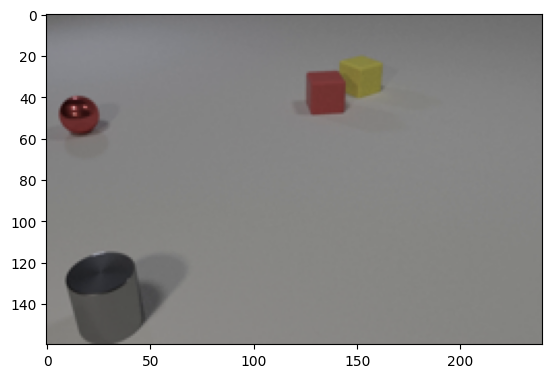

In [22]:
plt.imshow(target_img.permute(1, 2, 0))

In [67]:
#unstack the images
sample_imgs_unstack = torch.unbind(sample_imgs, dim=0)
output = model(sample_imgs.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)

In [68]:
output.shape

torch.Size([3, 160, 240])

In [72]:
#visualize the images and the target image in the end of the sequence
'''input: sample_imgs_unstack, target_img, output_img
   output: 13 images in a row with the last one is the target image and the title is the index of the image, and the output_img on the side of the target image, without the axes
   and save it to the out_dir'''
def visualize(sample_imgs_unstack, target_img, output_img, outpath = None):
    fig, axs = plt.subplots(1, 13, figsize=(20, 20))
    for i in range(11):
        axs[i].imshow(sample_imgs_unstack[i].permute(1, 2, 0))
        axs[i].set_title(i)
        axs[i].axis('off')
    axs[11].imshow(target_img.permute(1, 2, 0))
    axs[11].set_title('target')
    axs[11].axis('off')
    axs[12].imshow(output_img.permute(1, 2, 0), alpha=0.5)
    axs[12].set_title('output')
    axs[12].axis('off')
    plt.tight_layout()
    plt.show()
    # plt.savefig(outpath)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


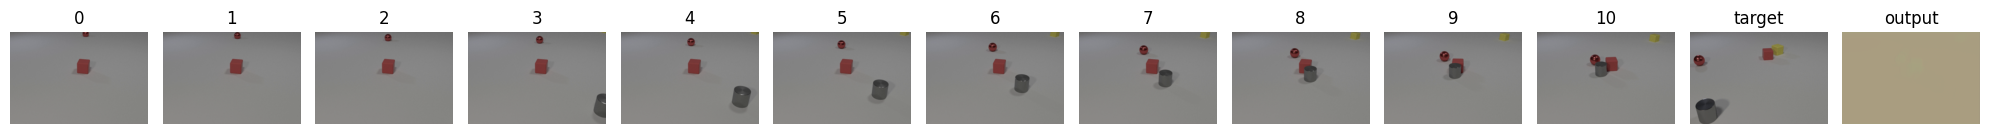

In [73]:
#visualize the model
visualize(sample_imgs_unstack, target_img, output)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
from tqdm import tqdm
n_epochs = 5
for epoch in tqdm(range(n_epochs)):
    total_loss = 0
    for x, target in dataloader:
        x = x.to(device)
        target = target.to(device)
        output = model(x)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(dataloader)))
        

  0%|          | 0/5 [23:34<?, ?it/s]


KeyboardInterrupt: 